In [94]:
"""
#The following commands are used to set up the environment in Colab
!apt-get -y install cuda-nvtx-11-8 cuda-libraries-11-8
%pip install cuda-quantum==0.8.0
"""

'\n#The following commands are used to set up the environment in Colab\n!apt-get -y install cuda-nvtx-11-8 cuda-libraries-11-8\n%pip install cuda-quantum==0.8.0\n'

In [95]:
!pip install pandas
!pip install networkx
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [96]:
import cudaq

print(cudaq.__version__)

import pandas as pd
import numpy as np
import math
import random
import networkx as nx
import matplotlib.pyplot as plt

CUDA-Q Version 0.8.0 (https://github.com/NVIDIA/cuda-quantum 5f63a898a1c4af1affd293fcc86220b683436f57)


# Set parameters and define qubit connectivity

In [97]:
num_qubits = 4*4
gate_set = ["rx", "ry", "sw"]  # https://www.nature.com/articles/s41586-019-1666-5

sequences, max_depth, step, shots = 10, 10, 1, 2**(num_qubits+5)
depths = np.arange(1, max_depth + 1, step) # Depths to be tested

dim = 2 ** num_qubits
num_gates = len(gate_set)

List of edges: [(0, 4), (0, 1), (1, 5), (1, 2), (2, 6), (2, 3), (3, 7), (4, 8), (4, 5), (5, 9), (5, 6), (6, 10), (6, 7), (7, 11), (8, 12), (8, 9), (9, 13), (9, 10), (10, 14), (10, 11), (11, 15), (12, 13), (13, 14), (14, 15)]


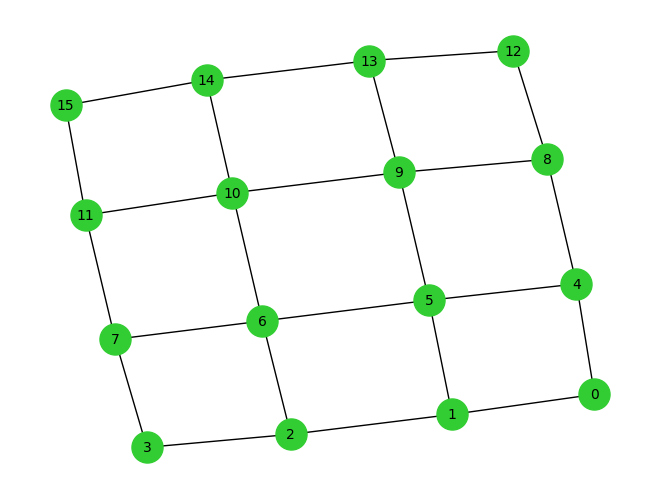

In [98]:
# Create a graph with grid topology representing qubit connectivity
grid_size = int(math.sqrt(num_qubits))
G = nx.grid_2d_graph(grid_size, grid_size)
G = nx.convert_node_labels_to_integers(G)

# Extract and print the list of edges/connectivity
connectivity = list(G.edges())
print("List of edges:", connectivity )

# Draw the graph
nx.draw(G, with_labels=True, node_color='limegreen', node_size=500, font_size=10)
plt.show()

# Define quantum kernel and custom quantum operation

In [99]:
cudaq.register_operation("sw", np.array([0.5+0.5j, -(1/math.sqrt(2))*1j, 1/math.sqrt(2), 0.5+0.5j]))

@cudaq.kernel
def kernel(num_qubits: int, sq_gates: list[int], selected_edges: list[int]):
    qubits = cudaq.qvector(num_qubits)

    h(qubits)
    for d in range(int(len(sq_gates)/num_qubits)):
        for p in range(int(len(selected_edges)/2)):
            q1, q2 = selected_edges[2*p], selected_edges[2*p+1]
            z.ctrl(qubits[q1], qubits[q2])
        for q in range(num_qubits):
            if sq_gates[int(d*num_qubits+q)] == 0:
                rx(math.pi/2, qubits[q])
            if sq_gates[int(d*num_qubits+q)] == 1:
                ry(math.pi/2, qubits[q])
            if sq_gates[int(d*num_qubits+q)] == 2:
                sw(qubits[q])

# Synthesize the group of gates and entanglements for quantum kernel contruction

In [100]:
# Function to rotate indices by 90 degrees clockwise
def rotate_index(index, size):
    i, j = divmod(index, size)
    return (size-1-j) * size + i


# Generate edges for entanglements
def select_edges(num_qubits):
    selected_edges = []
    size = int(np.sqrt(num_qubits))

    # Time frame 1
    for i in range(size):
        for j in range(size):
            idx = size*i + j
            if i%2 == 0:
                if j%4 == 2:
                    selected_edges.append((idx, idx+1))
            if i%2 == 1:
                if j%4 == 0:
                    selected_edges.append((idx, idx+1))
    # Time frame 2
    for i in range(size):
        for j in range(size):
            idx = size*i + j
            if i%2 == 0:
                if j%4 == 0:
                    selected_edges.append((idx, idx+1))
            if i%2 == 1:
                if j%4 == 2:
                    selected_edges.append((idx, idx+1))           
    # Time frame 3
    for i in range(size):
        for j in range(size):
            idx = size*i + j
            if i%4 == 1 and idx+size < num_qubits:
                if j%2 == 1:
                    selected_edges.append((idx, idx+size))
            if i%4 == 3  and idx+size < num_qubits:
                if j%2 == 0:
                    selected_edges.append((idx, idx+size))
    # Time frame 4
    for i in range(size):
        for j in range(size):
            idx = size*i + j
            if i%4 == 1 and idx+size < num_qubits:
                if j%2 == 0:
                    selected_edges.append((idx, idx+size))
            if i%4 == 3  and idx+size < num_qubits:
                if j%2 == 1:
                    selected_edges.append((idx, idx+size))
    # Time frame 5
    for i in range(size):
        for j in range(size):
            idx = size*i + j
            if i%4 == 1 and idx+size < num_qubits:
                if j%2 == 0:
                    selected_edges.append((rotate_index(idx, size), rotate_index(idx+size, size)))
            if i%4 == 3  and idx+size < num_qubits:
                if j%2 == 1:
                    selected_edges.append((rotate_index(idx, size), rotate_index(idx+size, size)))
    # Time frame 6
    for i in range(size):
        for j in range(size):
            idx = size*i + j
            if i%4 == 1 and idx+size < num_qubits:
                if j%2 == 1:
                    selected_edges.append((rotate_index(idx, size), rotate_index(idx+size, size)))
            if i%4 == 3  and idx+size < num_qubits:
                if j%2 == 0:
                    selected_edges.append((rotate_index(idx, size), rotate_index(idx+size, size)))
    # Time frame 7
    for i in range(size):
        for j in range(size):
            idx = size*i + j
            if i%2 == 0:
                if j%4 == 0:
                    selected_edges.append((rotate_index(idx, size), rotate_index(idx+1, size)))
            if i%2 == 1:
                if j%4 == 2:
                    selected_edges.append((rotate_index(idx, size), rotate_index(idx+1, size)))
    # Time frame 8
    for i in range(size):
        for j in range(size):
            idx = size*i + j
            if i%2 == 0:
                if j%4 == 2:
                    selected_edges.append((rotate_index(idx, size), rotate_index(idx+1, size)))
            if i%2 == 1:
                if j%4 == 0:
                    selected_edges.append((rotate_index(idx, size), rotate_index(idx+1, size)))

    # Flatten the list of the tuples/edges
    selected_edges = [int(node) for edge in selected_edges for node in edge]

    return selected_edges


# Example usage

selected_edges = select_edges(num_qubits)
print(selected_edges)

[2, 3, 4, 5, 10, 11, 12, 13, 0, 1, 6, 7, 8, 9, 14, 15, 5, 9, 7, 11, 4, 8, 6, 10, 13, 14, 5, 6, 9, 10, 1, 2, 12, 8, 5, 1, 14, 10, 7, 3, 4, 0, 13, 9, 6, 2, 15, 11]


In [101]:
# Initialize lists
sq_gates = []
selected_edges = select_edges(num_qubits)

# Generate sequences for each d-depth circuit
np.random.seed(13111)
for d in depths:
    sq_gates.append([])
    for s in range(sequences):

        gates = np.zeros((num_qubits, d), dtype=int)
        for q in range(num_qubits):
            gates[q][0] = np.random.randint(num_gates)  # First gate
            for d_ in range(1, d):
                gates[q][d_] = np.random.randint(num_gates)
                while gates[q][d_] == gates[q][d_ - 1]:
                    gates[q][d_] = np.random.randint(num_gates)

        gates = [int(g) for g in gates.reshape(-1)]  # Convert numpy int64 elements to int
        sq_gates[-1].append(gates)


#print(sq_gates)
#print(selected_edges)

In [102]:
print(cudaq.draw(kernel, num_qubits, sq_gates[3][0], selected_edges))

      ╭───╮                                                    ╭───╮    »
 q0 : ┤ h ├──●─────────────────────────────────────────────────┤ z ├────»
      ├───┤╭─┴─╮                         ╭───╮                 ╰─┬─╯    »
 q1 : ┤ h ├┤ z ├──●──────────────────────┤ z ├───────────────────┼──────»
      ├───┤╰───╯╭─┴─╮                    ╰─┬─╯                   │      »
 q2 : ┤ h ├──●──┤ z ├──────────────────────┼─────────────────────┼──────»
      ├───┤╭─┴─╮╰───╯                      │      ╭───╮          │      »
 q3 : ┤ h ├┤ z ├───────────────────────────┼──────┤ z ├──────────┼──────»
      ├───┤╰───╯                           │      ╰─┬─╯          │      »
 q4 : ┤ h ├──●──────────────●──────────────┼────────┼────────────●──────»
      ├───┤╭─┴─╮            │              │        │                   »
 q5 : ┤ h ├┤ z ├──●─────────┼─────────●────●────────┼───────────────────»
      ├───┤╰───╯  │         │       ╭─┴─╮           │                   »
 q6 : ┤ h ├──●────┼─────────┼────●──┤ 

# Noiseless Simulation

In [103]:
cudaq.set_target('nvidia')

# Process sequences with CUDA-Q
states_list, counts_list= [], []

for d in range(max_depth):
    states_list.append([])
    for s in range(sequences):
        states = np.array(cudaq.get_state(kernel, num_qubits, sq_gates[d][s], selected_edges))
        states_list[d].append(states)

        sample_result = cudaq.sample(kernel, num_qubits, sq_gates[d][s], selected_edges)
        counts = dict(sample_result.items())
        counts_list.append(counts)


print(states_list)
print(counts_list)

[[array([-0.00175087+0.00089279j, -0.00020225-0.00325042j,
        0.00325042-0.00117881j, ...,  0.00186935+0.00117881j,
        0.00020225+0.00089279j, -0.00767965-0.00325042j], dtype=complex64), array([ 0.00276213+0.00138107j,  0.0037387 +0.00097656j,
       -0.00488281+0.00097656j, ..., -0.0037387 -0.00097656j,
       -0.00097656-0.00292969j, -0.00195312+0.00333419j], dtype=complex64), array([-2.7398966e-10-0.00390625j, -6.6683833e-03+0.00666838j,
        1.8667815e-10+0.00943052j, ...,  1.1441133e-03-0.00276213j,
       -2.7621344e-03-0.00114411j,  2.7621344e-03+0.00666838j],
      dtype=complex64), array([-0.00138107+0.00057206j,  0.00057206-0.00138107j,
        0.00138107+0.00609632j, ..., -0.00057206-0.00138107j,
        0.00138107-0.00609633j,  0.00609632-0.00138107j], dtype=complex64), array([ 0.00097656+0.00235763j,  0.00097656-0.00040451j,
       -0.00626388+0.00097656j, ...,  0.00235763+0.00097656j,
        0.00259458+0.00040451j,  0.0037387 -0.00511976j], dtype=complex64),